In [1]:
!which python

/scratch/ci411/.conda/envs/py3.8/bin/python


In [7]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import seaborn as sns
from seaborn import pointplot
from keras.models import model_from_yaml
#from librosa.display import specshow
from IPython.display import Audio
from tqdm import tqdm


sys.path.append('/home/ci411/pcen-t-varying/')

import pcen_t.eval
from pcen_t.utils import *
from pcen_t.models import SqueezeLayer


URBANSED_CLASSES = ['air_conditioner',
                    'car_horn',
                    'children_playing',
                    'dog_bark',
                    'drilling',
                    'engine_idling',
                    'gun_shot',
                    'jackhammer',
                    'siren',
                    'street_music']

In [8]:
slices_single = [str(i) for i in range(10)]
slices_multiple = [''.join(str(j) for j in np.arange(i+1)) for i in range(10)]
slices_midout = [''.join(str(j) for j in np.arange(n, 10-n)) for n in range(4,-1,-1)]
slices_midout.insert(0, '5')

real_reverb_set = ['bedroom','alley','tunnel']
sim_reverb_set = ['short','medium','long']

In [9]:
sample_df = pd.read_csv('sampled_results.csv', index_col=0)
sample_df['slices'] = sample_df['version'].map(lambda x : str(x.split('_')[1]))
sample_df['modelset'] = sample_df['version'].map(lambda x : str(x.split('_')[2]))

/scratch/ci411/.conda/envs/py3.8/lib/python3.8/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [10]:
sample_df['num_slices'] = sample_df['slices'].apply(lambda x : len(str(x)))

mel_rows = sample_df['slices'] == 'mel'
sample_df.loc[sample_df['slices'] == 'mel','num_slices'] = 0
sample_df.sample(25)

,version,training_set,slices,eval_dataset,model,class/metric,value,metric,class,modelset,num_slices
111707,simreverb_9_1014,simreverb,9,dry,cnn_l3_strong,overall_r,0.322122,recall,overall,1014,1
1472445,dry_8_1014,dry,8,short,cnn_l3_strong,dog_bark_e,1.107914,error_rate,dog_bark,1014,1
2370009,dry_012345678_1014,dry,012345678,short,cnn_l3_strong,gun_shot_f1,0.124031,f_measure,gun_shot,1014,9
3047632,dry_5_1014,dry,5,wet,cnn_l3_strong,siren_e,1.019293,error_rate,siren,1014,1
421150,realreverb_01234_1014,realreverb,01234,bedroom,cnn_l3_strong,air_conditioner_r,0.033898,recall,air_conditioner,1014,5
944576,simreverb_0_1014,simreverb,0,medium,cnn_l3_strong,children_playing_p,0.393443,precision,children_playing,1014,1
993400,realreverb_0123456789_1014,realreverb,0123456789,long,cnn_l3_strong,children_playing_p,0.285714,precision,children_playing,1014,10
1065311,dry_7_1014,dry,7,tunnel,cnn_l3_strong,children_playing_r,0.243243,recall,children_playing,1014,1
1024428,dry_234567_1014,dry,234567,dry,cnn_l3_strong,children_playing_r,0.408451,recall,children_playing,1014,6
1960435,simreverb_mel_1014,simreverb,mel,bedroom,cnn_l3_strong,engine_idling_r,0.375000,recall,engine_idling,1014,0


In [11]:
#DROP NANs
sample_df = sample_df.dropna(subset=['value'])

<ipython-input-12-9175d659b572>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  f1_df = sample_df[sample_df['metric']=='f_measure']\


Text(0.5, 0, '$\\log_2(T)$')

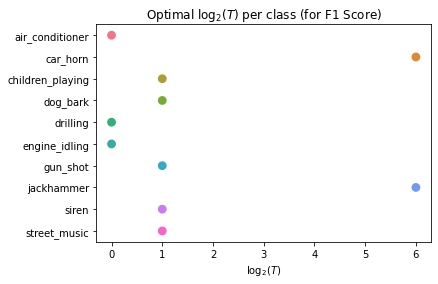

In [12]:
f1_df = sample_df[sample_df['metric']=='f_measure']\
                 [sample_df['training_set']=='dry']\
                 [sample_df['eval_dataset']=='dry']
f1_single_df = f1_df[f1_df['num_slices']==1]
f1_classgroup = f1_single_df.groupby('class')
best_single_slice = {}
for key, item in f1_classgroup:
    mean_series = f1_classgroup.get_group(key).groupby('slices').mean()
    max_slice = mean_series['value'].argmax()
    best_single_slice[key] = max_slice

classes = ['air_conditioner', 'car_horn', 'children_playing',\
           'dog_bark', 'drilling', 'engine_idling', 'gun_shot',\
           'jackhammer', 'siren', 'street_music']

best_slices = [best_single_slice[c] for c in classes]
sns.pointplot(x=best_slices, y=classes, join=False, palette='husl')
plt.title(r"Optimal $\log_2(T)$ per class (for F1 Score)")
plt.xlabel(r"$\log_2(T)$")

In [13]:
f1_df['version'].unique()

array(['dry_2_1014', 'dry_1_1014', 'dry_0_1014', 'dry_8_1014',
       'dry_012345_1014', 'dry_9_1014', 'dry_234567_1014',
       'dry_12345678_1014', 'dry_01234567_1014', 'dry_0123_1014',
       'dry_45_1014', 'dry_0123456789_1014', 'dry_01_1014', 'dry_5_1014',
       'dry_01234_1014', 'dry_0123456_1014', 'dry_012_1014', 'dry_4_1014',
       'dry_012345678_1014', 'dry_7_1014', 'dry_3456_1014',
       'dry_mel_1014', 'dry_6_1014', 'dry_3_1014'], dtype=object)

<ipython-input-14-c016d1f82b23>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  f1_df = sample_df[sample_df['metric']=='f_measure']\


Text(0.5, 0.98, 'Dry-trained models performance on wet/dry eval datasets')

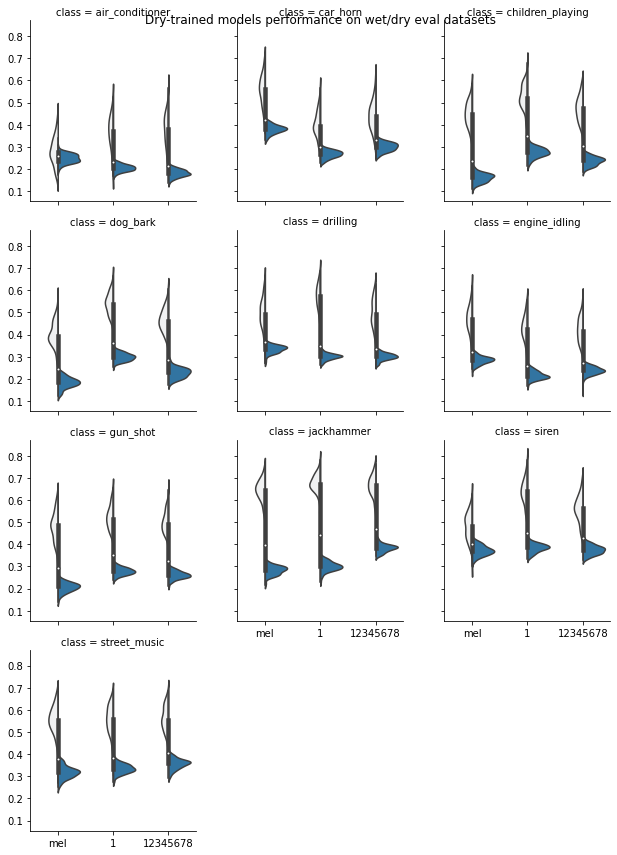

In [14]:
compare_models = ['dry_mel_1014', 'dry_1_1014', 'dry_12345678_1014']
model_labels = [item.split('_')[1] for item in compare_models]

f1_df = sample_df[sample_df['metric']=='f_measure']\
                 [sample_df['version'].isin(compare_models)]\
                 [sample_df['eval_dataset'].isin(['dry','wet'])]

g = sns.FacetGrid(f1_df, col="class", col_wrap=3, col_order=URBANSED_CLASSES, legend_out=True)
g.map_dataframe(sns.violinplot, x='version', y='value', hue='eval_dataset',\
                split=True, order=compare_models, hue_order=['dry','wet'])
for ax in g.axes.flat:
    ax.set_xticklabels(model_labels)
    
g.fig.suptitle('Dry-trained models performance on wet/dry eval datasets')

In [15]:
f1_df = sample_df[sample_df['metric']=='f_measure']\
                 [sample_df['training_set']=='realreverb']\
                 [sample_df['eval_dataset'].isin(real_reverb_set)]\
                 [sample_df['class']=='overall']
f1_single_df = f1_df[f1_df['num_slices']==1]
f1_increasing_df = f1_df[f1_df['slices'].isin(slices_multiple)]
f1_midout_df = f1_df[f1_df['slices'].isin(slices_midout)]
f1_mel_df = f1_df[f1_df['num_slices']==0]

<ipython-input-15-de8be18bcef9>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  f1_df = sample_df[sample_df['metric']=='f_measure']\


<ipython-input-16-5c27e71fdd2d>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  f1_df = sample_df[sample_df['metric']=='f_measure']\
<ipython-input-16-5c27e71fdd2d>:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dry_mel_median = mel_medians_df[mel_medians_df['class']==class_label]\
<ipython-input-16-5c27e71fdd2d>:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  wet_mel_median = mel_medians_df[mel_medians_df['class']==class_label]\
<ipython-input-16-5c27e71fdd2d>:36: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dry_mr_median = mr_medians_df[mr_medians_df['class']==class_label]\
<ipython-input-16-5c27e71fdd2d>:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  wet_mr_median = mr_medians_df[mr_medians_df['class']==class_label]\


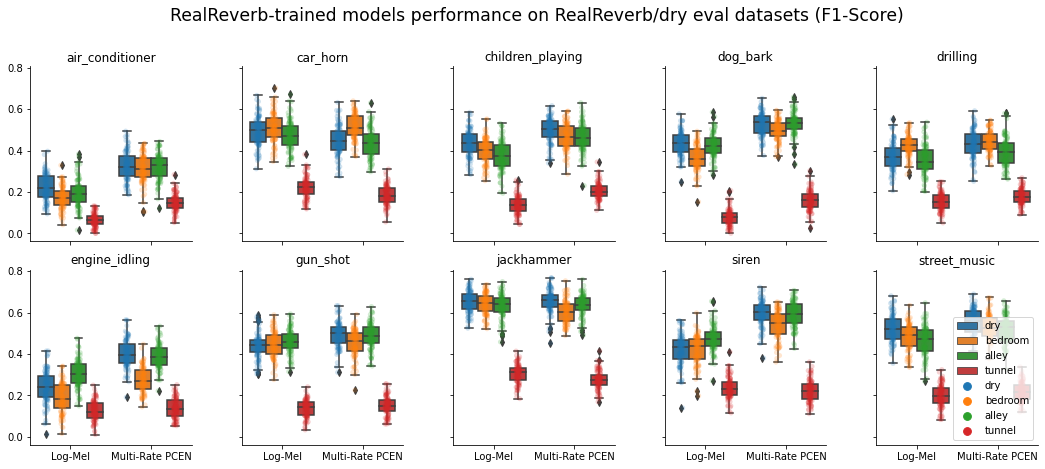

In [16]:
compare_models = ['realreverb_mel_1014','realreverb_12345678_1014']
model_labels = ['Log-Mel', 'Multi-Rate PCEN']

f1_df = sample_df[sample_df['metric']=='f_measure']\
                 [sample_df['version'].isin(compare_models)]\
                 [sample_df['eval_dataset'].isin(['dry']+real_reverb_set)]

g = sns.FacetGrid(f1_df, col="class", col_wrap=5, col_order=URBANSED_CLASSES, legend_out=True)
g.map_dataframe(sns.boxplot, x='version', y='value', hue='eval_dataset',\
                order=compare_models, hue_order=['dry']+real_reverb_set, palette=sns.color_palette("tab10"))
g.map_dataframe(sns.stripplot, x='version', y='value', hue='eval_dataset',\
                order=compare_models, hue_order=['dry']+real_reverb_set, dodge=True, jitter=True,\
                palette=sns.color_palette("tab10"), alpha=.2)

mel_x_coords = [-.2, 0.2]
mr_x_coords = [0.8, 1.2]


medians_df = f1_df.groupby(['version','class','eval_dataset']).median().reset_index()
means_df = f1_df.groupby(['version','class','eval_dataset']).mean().reset_index()
mr_medians_df = means_df[means_df['version']==compare_models[1]].drop(['version','num_slices'],axis=1)
mel_medians_df = means_df[means_df['version']==compare_models[0]].drop(['version','num_slices'],axis=1)

for i, ax in enumerate(g.axes.flat):
    ax.set_xticklabels(model_labels)
    class_label = ax.title.get_text().split(' ')[-1]
    ax.set_title(class_label)
    dry_mel_median = mel_medians_df[mel_medians_df['class']==class_label]\
                                   [mel_medians_df['eval_dataset']=='dry']\
                                   ['value'].tolist()[0]
    wet_mel_median = mel_medians_df[mel_medians_df['class']==class_label]\
                                   [mel_medians_df['eval_dataset'].isin(real_reverb_set)]\
                                   ['value'].tolist()[0]
    #ax.plot(mel_x_coords, [dry_mel_median, wet_mel_median], 'r--')
    
    dry_mr_median = mr_medians_df[mr_medians_df['class']==class_label]\
                                 [mr_medians_df['eval_dataset']=='dry']\
                                 ['value'].tolist()[0]
    wet_mr_median = mr_medians_df[mr_medians_df['class']==class_label]\
                                 [mr_medians_df['eval_dataset'].isin(real_reverb_set)]\
                                 ['value'].tolist()[0]
    #ax.plot(mr_x_coords, [dry_mr_median, wet_mr_median], 'r--')
    
    

g.fig.suptitle('RealReverb-trained models performance on RealReverb/dry eval datasets (F1-Score)', y=1.08, fontsize='xx-large')

'''legend_elements = []
legend_elements.append(Patch(facecolor=sns.color_palette("tab10")[0],label='Evaluation on Dry Data'))
legend_elements.append(Patch(facecolor=sns.color_palette("tab10")[1],label='Evaluation on Wet Data'))
'''

plt.legend()#handles=legend_elements, bbox_to_anchor=(0.1,2.4,.9,.2), mode='expand', loc='upper left')

In [17]:
compare_models = ['simreverb_mel_1014','simreverb_12345678_1014']
model_labels = ['Log-Mel', 'Multi-Rate PCEN']

f1_df = sample_df[sample_df['metric']=='f_measure']\
                 [sample_df['version'].isin(compare_models)]\
                 [sample_df['eval_dataset'].isin(['dry']+sim_reverb_set)]

wet_eval_df = f1_df[f1_df['eval_dataset'].isin(sim_reverb_set)]
dry_eval_df = f1_df[f1_df['eval_dataset']=='dry']

wet_means_df = wet_eval_df.groupby(['version','class']).mean()
wet_std_df = wet_eval_df.groupby(['version','class']).std()

dry_means_df = dry_eval_df.groupby(['version','class']).mean()
dry_std_df = dry_eval_df.groupby(['version','class']).std()

vertical_welch_df = ((dry_means_df['value'] - wet_means_df['value']) /\
                    np.sqrt(wet_std_df['value']**2/100 + dry_std_df['value']**2/100))\
                    .to_frame().reset_index()

mr_welch = vertical_welch_df[vertical_welch_df['version']==compare_models[1]]
mel_welch = vertical_welch_df[vertical_welch_df['version']==compare_models[0]]

welch_df = mel_welch.merge(mr_welch, on='class', suffixes=('_mel', '_mr'))
welch_df = welch_df[['version_mel', 'version_mr', 'class', 'value_mel', 'value_mr']]

welch_df

<ipython-input-17-79a60752103e>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  f1_df = sample_df[sample_df['metric']=='f_measure']\


,version_mel,version_mr,class,value_mel,value_mr
0,simreverb_mel_1014,simreverb_12345678_1014,air_conditioner,12.253103,18.396793
1,simreverb_mel_1014,simreverb_12345678_1014,car_horn,34.492677,26.585327
2,simreverb_mel_1014,simreverb_12345678_1014,children_playing,35.894475,31.034953
3,simreverb_mel_1014,simreverb_12345678_1014,dog_bark,34.483510,38.442767
4,simreverb_mel_1014,simreverb_12345678_1014,drilling,17.271472,22.807056
5,simreverb_mel_1014,simreverb_12345678_1014,engine_idling,24.801696,25.207292
6,simreverb_mel_1014,simreverb_12345678_1014,gun_shot,47.325498,48.759399
7,simreverb_mel_1014,simreverb_12345678_1014,jackhammer,47.153913,48.609877
8,simreverb_mel_1014,simreverb_12345678_1014,overall,104.068528,112.338952
9,simreverb_mel_1014,simreverb_12345678_1014,siren,22.611102,42.234246


<ipython-input-18-c57b9f486e44>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  f1_df = sample_df[sample_df['metric']=='f_measure']\
<ipython-input-18-c57b9f486e44>:30: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dry_mel_median = mel_medians_df[mel_medians_df['class']==class_label]\
<ipython-input-18-c57b9f486e44>:33: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  wet_mel_median = mel_medians_df[mel_medians_df['class']==class_label]\
<ipython-input-18-c57b9f486e44>:38: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dry_mr_median = mr_medians_df[mr_medians_df['class']==class_label]\
<ipython-input-18-c57b9f486e44>:41: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  wet_mr_median = mr_medians_df[mr_medians_df['class']==class_label]\


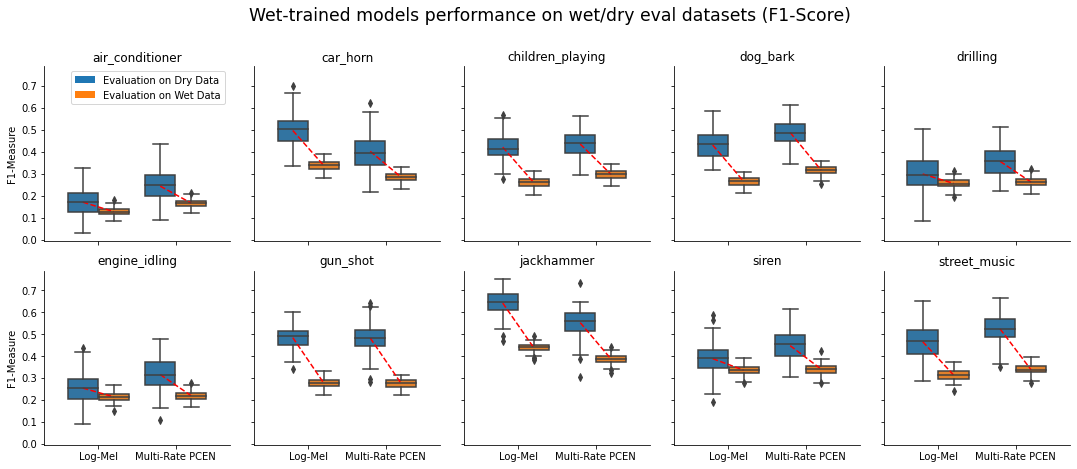

In [18]:
compare_models = ['wet_mel_1014','wet_12345678_1014']
model_labels = ['Log-Mel', 'Multi-Rate PCEN']

f1_df = sample_df[sample_df['metric']=='f_measure']\
                 [sample_df['version'].isin(compare_models)]\
                 [sample_df['eval_dataset'].isin(['dry','wet'])]

g = sns.FacetGrid(f1_df, col="class", col_wrap=5, col_order=URBANSED_CLASSES, legend_out=True)
g.map_dataframe(sns.boxplot, x='version', y='value', hue='eval_dataset',\
                order=compare_models, hue_order=['dry','wet'], palette=sns.color_palette("tab10"))
#g.map_dataframe(sns.stripplot, x='version', y='value', hue='eval_dataset',\
#                order=compare_models, hue_order=['dry','wet'], dodge=True, jitter=True,\
#                palette=sns.color_palette("tab10"), alpha=.2)

mel_x_coords = [-.2, 0.2]
mr_x_coords = [0.8, 1.2]


medians_df = f1_df.groupby(['version','class','eval_dataset']).median().reset_index()
means_df = f1_df.groupby(['version','class','eval_dataset']).mean().reset_index()
mr_medians_df = means_df[means_df['version']=='wet_12345678_1014'].drop(['version','num_slices'],axis=1)
mel_medians_df = means_df[means_df['version']=='wet_mel_1014'].drop(['version','num_slices'],axis=1)

for i, ax in enumerate(g.axes.flat):
    if i%5==0:
        ax.set_ylabel('F1-Measure')
    ax.set_xticklabels(model_labels)
    class_label = ax.title.get_text().split(' ')[-1]
    ax.set_title(class_label)
    dry_mel_median = mel_medians_df[mel_medians_df['class']==class_label]\
                                   [mel_medians_df['eval_dataset']=='dry']\
                                   ['value'].tolist()[0]
    wet_mel_median = mel_medians_df[mel_medians_df['class']==class_label]\
                                   [mel_medians_df['eval_dataset']=='wet']\
                                   ['value'].tolist()[0]
    ax.plot(mel_x_coords, [dry_mel_median, wet_mel_median], 'r--')
    
    dry_mr_median = mr_medians_df[mr_medians_df['class']==class_label]\
                                 [mr_medians_df['eval_dataset']=='dry']\
                                 ['value'].tolist()[0]
    wet_mr_median = mr_medians_df[mr_medians_df['class']==class_label]\
                                 [mr_medians_df['eval_dataset']=='wet']\
                                 ['value'].tolist()[0]
    ax.plot(mr_x_coords, [dry_mr_median, wet_mr_median], 'r--')
    
    

g.fig.suptitle('Wet-trained models performance on wet/dry eval datasets (F1-Score)', y=1.08, fontsize='xx-large')

legend_elements = []
legend_elements.append(Patch(facecolor=sns.color_palette("tab10")[0],label='Evaluation on Dry Data'))
legend_elements.append(Patch(facecolor=sns.color_palette("tab10")[1],label='Evaluation on Wet Data'))


g.axes.flat[0].legend(handles=legend_elements,loc='upper right')
g.fig.savefig('mel_multi_compare_nostrip.pdf', format='pdf')

In [19]:
for model2 in tqdm(sample_df['version'].unique()):
    compare_models = ['wet_mel_1014', model2]
    model_labels = ['Log-Mel', 'Multi-Rate PCEN']

    f1_df = sample_df[sample_df['metric']=='f_measure']\
                     [sample_df['version'].isin(compare_models)]\
                     [sample_df['eval_dataset'].isin(['dry','wet'])]

    wet_eval_df = f1_df[f1_df['eval_dataset']=='wet']
    dry_eval_df = f1_df[f1_df['eval_dataset']=='dry']

    wet_means_df = wet_eval_df.groupby(['version','class']).mean()
    wet_std_df = wet_eval_df.groupby(['version','class']).std()

    dry_means_df = dry_eval_df.groupby(['version','class']).mean()
    dry_std_df = dry_eval_df.groupby(['version','class']).std()

    vertical_welch_df = ((dry_means_df['value'] - wet_means_df['value']) /\
                        np.sqrt(wet_std_df['value']**2/100 + dry_std_df['value']**2/100))\
                        .to_frame().reset_index()

    mr_welch = vertical_welch_df[vertical_welch_df['version']==model2]
    mel_welch = vertical_welch_df[vertical_welch_df['version']=='wet_mel_1014']

    welch_df = mel_welch.merge(mr_welch, on='class', suffixes=('_mel', '_mr'))
    welch_df = welch_df[['version_mel', 'version_mr', 'class', 'value_mel', 'value_mr']]

    tot_improv = np.sum(welch_df['value_mel'] > welch_df['value_mr'])
    if tot_improv>= 5:
        print(tot_improv, model2)
    

  0%|          | 0/96 [00:00<?, ?it/s]<ipython-input-19-2d44553d2136>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  f1_df = sample_df[sample_df['metric']=='f_measure']\
  2%|▏         | 2/96 [00:00<00:40,  2.30it/s]

5 simreverb_3456_1014


 18%|█▊        | 17/96 [00:07<00:34,  2.26it/s]

8 dry_8_1014


 23%|██▎       | 22/96 [00:09<00:32,  2.25it/s]

10 dry_9_1014


 24%|██▍       | 23/96 [00:10<00:32,  2.27it/s]

6 simreverb_8_1014


 27%|██▋       | 26/96 [00:11<00:30,  2.29it/s]

5 simreverb_0123456_1014


 28%|██▊       | 27/96 [00:11<00:30,  2.29it/s]

5 realreverb_0123_1014


 38%|███▊      | 36/96 [00:15<00:26,  2.28it/s]

5 simreverb_01234_1014


 40%|███▉      | 38/96 [00:16<00:25,  2.27it/s]

5 wet_0123_1014


 43%|████▎     | 41/96 [00:18<00:24,  2.21it/s]

5 wet_6_1014


 50%|█████     | 48/96 [00:21<00:21,  2.27it/s]

5 wet_234567_1014


 52%|█████▏    | 50/96 [00:22<00:20,  2.27it/s]

6 wet_2_1014


 64%|██████▎   | 61/96 [00:26<00:15,  2.25it/s]

6 wet_4_1014


 67%|██████▋   | 64/96 [00:28<00:14,  2.25it/s]

6 simreverb_3_1014


 73%|███████▎  | 70/96 [00:30<00:11,  2.27it/s]

5 simreverb_45_1014


 74%|███████▍  | 71/96 [00:31<00:10,  2.28it/s]

5 wet_8_1014


 88%|████████▊ | 84/96 [00:37<00:05,  2.28it/s]

6 dry_7_1014


 89%|████████▊ | 85/96 [00:37<00:04,  2.26it/s]

5 wet_9_1014


 92%|█████████▏| 88/96 [00:38<00:03,  2.29it/s]

5 realreverb_4_1014


 93%|█████████▎| 89/96 [00:39<00:03,  2.27it/s]

5 simreverb_6_1014


 98%|█████████▊| 94/96 [00:41<00:00,  2.26it/s]

5 wet_01234_1014


100%|██████████| 96/96 [00:42<00:00,  2.27it/s]


In [20]:
compare_models = ['wet_mel_1014', 'wet_12345678_1014']
model_labels = ['Log-Mel', 'Multi-Rate PCEN']

f1_df = sample_df[sample_df['metric']=='f_measure']\
                 [sample_df['version'].isin(compare_models)]\
                 [sample_df['eval_dataset'].isin(['dry','wet'])]

wet_eval_df = f1_df[f1_df['eval_dataset']=='wet']
dry_eval_df = f1_df[f1_df['eval_dataset']=='dry']

wet_means_df = wet_eval_df.groupby(['version','class']).mean()
wet_std_df = wet_eval_df.groupby(['version','class']).std()

dry_means_df = dry_eval_df.groupby(['version','class']).mean()
dry_std_df = dry_eval_df.groupby(['version','class']).std()

vertical_welch_df = ((dry_means_df['value'] - wet_means_df['value']) /\
                    np.sqrt(wet_std_df['value']**2/100 + dry_std_df['value']**2/100))\
                    .to_frame().reset_index()

mr_welch = vertical_welch_df[vertical_welch_df['version']==compare_models[1]]
mel_welch = vertical_welch_df[vertical_welch_df['version']=='wet_mel_1014']

welch_df = mel_welch.merge(mr_welch, on='class', suffixes=('_mel', '_mr'))
welch_df = welch_df[['version_mel', 'version_mr', 'class', 'value_mel', 'value_mr']]

<ipython-input-20-7bb6ca2d9b82>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  f1_df = sample_df[sample_df['metric']=='f_measure']\


In [21]:
welch_df[welch_df['value_mr']<welch_df['value_mel']]

,version_mel,version_mr,class,value_mel,value_mr
1,wet_mel_1014,wet_12345678_1014,car_horn,21.960487,14.449692
2,wet_mel_1014,wet_12345678_1014,children_playing,25.461322,22.210495
6,wet_mel_1014,wet_12345678_1014,gun_shot,35.473617,30.337275
7,wet_mel_1014,wet_12345678_1014,jackhammer,34.774217,24.554459


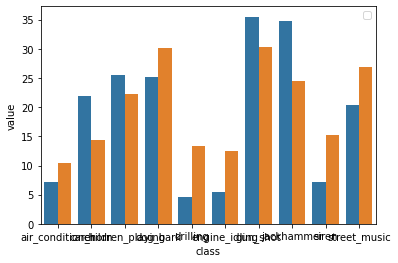

In [22]:
sns.barplot(data=vertical_welch_df, x='class', y='value', hue='version',\
            order=URBANSED_CLASSES, hue_order=compare_models)

plt.legend(handles=legend_elements, bbox_to_anchor=(0.1,2.4,.9,.2), mode='expand', loc='upper left')
plt.legend('')

In [23]:
mel_medians_df[mel_medians_df['class']==class_label]\
                                   [mel_medians_df['eval_dataset']=='dry']\
                                   ['value'].tolist()[0]

<ipython-input-23-be24b8bd9cd0>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  mel_medians_df[mel_medians_df['class']==class_label]\


0.466993944442652

<ipython-input-24-897a51f26c91>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  wet_df = sample_df[sample_df['metric']=='f_measure']\
<ipython-input-24-897a51f26c91>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dry_df = sample_df[sample_df['metric']=='f_measure']\


Text(0.5, 0.98, 'Performance drop across classes')

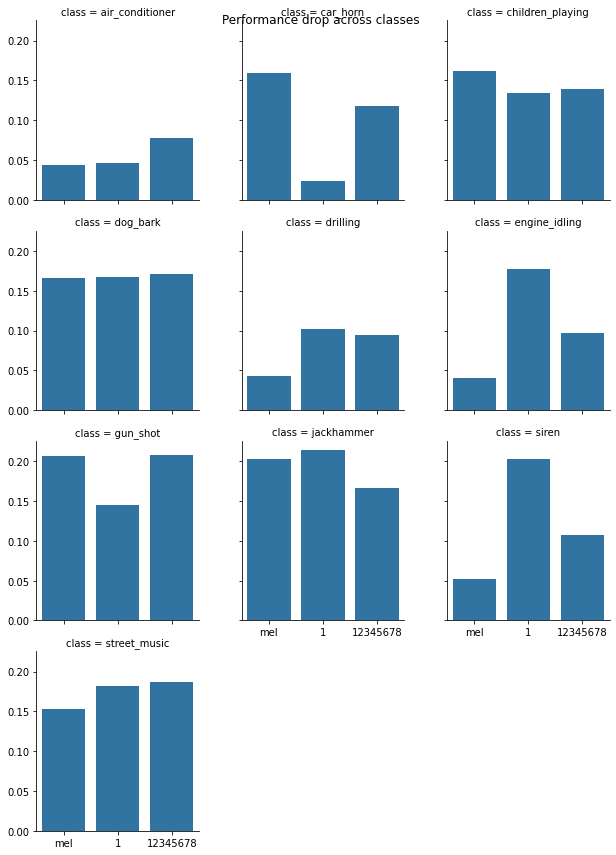

In [24]:
#extracting evaluations on wet data
wet_df = sample_df[sample_df['metric']=='f_measure']\
                  [sample_df['training_set'].isin(['dry','wet'])]\
                  [sample_df['eval_dataset'].isin(['wet'])]

wet_gb = wet_df.groupby(by=['version','class'])
wet_mean_df = wet_gb.mean().reset_index()
wet_mean_df['training_set'] = wet_mean_df['version'].apply(lambda row:row.split('_')[0])

#extracting evaluations on dry data
dry_df = sample_df[sample_df['metric']=='f_measure']\
                  [sample_df['training_set'].isin(['dry','wet'])]\
                  [sample_df['eval_dataset'].isin(['dry'])]

dry_gb = dry_df.groupby(by=['version','class'])
dry_mean_df = dry_gb.mean().reset_index()
dry_mean_df['training_set'] = dry_mean_df['version'].apply(lambda row:row.split('_')[0])

means_compare_df = dry_mean_df.merge(wet_mean_df, on=['version', 'class'], suffixes=('_dry', '_wet'))
means_compare_df = means_compare_df.drop(axis=1, labels=['num_slices_wet', 'training_set_wet'])\
                                   .rename(axis=1, mapper={'num_slices_dry':'num_slices',\
                                                           'training_set_dry':'training_set'})

means_compare_df['f1_drop'] = means_compare_df['value_dry'] - means_compare_df['value_wet']
means_compare_df['f1_ratio'] = means_compare_df['value_wet'] / means_compare_df['value_dry']

compare_models = ['wet_mel_1014', 'wet_1_1014', 'wet_12345678_1014']
model_labels = [item.split('_')[1] for item in compare_models]

means_compare_df = means_compare_df[means_compare_df['version'].isin(compare_models)]

g = sns.FacetGrid(means_compare_df, col="class", col_wrap=3, col_order=URBANSED_CLASSES, legend_out=True)
g.map_dataframe(sns.barplot, x='version', y='f1_drop', order=compare_models)

for ax in g.axes.flat:
    ax.set_xticklabels(model_labels)
    
g.fig.suptitle('Performance drop across classes')

,value_dry,num_slices,value_wet,f1_drop,f1_ratio
version,,,,,
wet_12345678_1014,0.436252,8,0.289141,0.136471,0.683019
wet_1_1014,0.398368,1,0.281578,0.145066,0.650106
wet_mel_1014,0.422136,0,0.277966,0.152838,0.683608


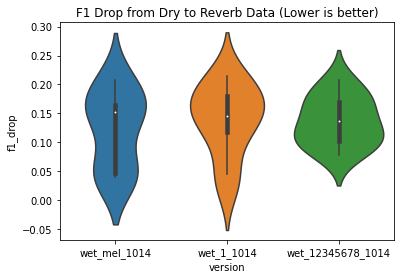

In [25]:
sns.violinplot(data=means_compare_df, x='version', y = 'f1_drop', order=compare_models)
plt.title('F1 Drop from Dry to Reverb Data (Lower is better)')
means_compare_df.groupby('version').median()

,value_dry,num_slices,value_wet,f1_drop,f1_ratio
version,,,,,
wet_12345678_1014,0.436252,8,0.289141,0.136471,0.683019
wet_1_1014,0.398368,1,0.281578,0.145066,0.650106
wet_mel_1014,0.422136,0,0.277966,0.152838,0.683608


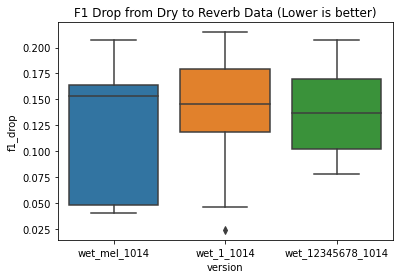

In [26]:
sns.boxplot(data=means_compare_df, x='version', y = 'f1_drop', order=compare_models)
plt.title('F1 Drop from Dry to Reverb Data (Lower is better)')
means_compare_df.groupby('version').median()

,value_dry,num_slices,value_wet,f1_drop,f1_ratio
version,,,,,
wet_12345678_1014,0.436252,8,0.289141,0.136471,0.683019
wet_1_1014,0.398368,1,0.281578,0.145066,0.650106
wet_mel_1014,0.422136,0,0.277966,0.152838,0.683608


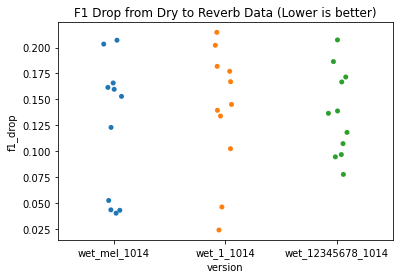

In [27]:
sns.stripplot(data=means_compare_df, x='version', y = 'f1_drop', order=compare_models, jitter=True)
plt.title('F1 Drop from Dry to Reverb Data (Lower is better)')
means_compare_df.groupby('version').median()

Text(0.5, 1.0, 'F1 Wet : F1 Dry (Higher is better)')

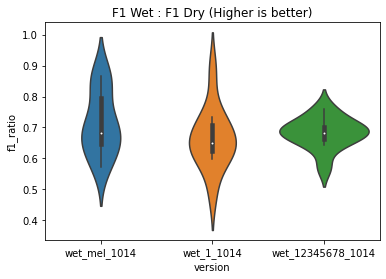

In [28]:
sns.violinplot(data=means_compare_df, x='version', y = 'f1_ratio', order=compare_models)
plt.title('F1 Wet : F1 Dry (Higher is better)')

In [29]:
item_array = [np.array(item.split('_'))for item in URBANSED_CLASSES]
class_labels = []
for item in item_array:
    output = ''
    for word in item:
        output += word[0]
    class_labels.append(output)
class_labels

['ac', 'ch', 'cp', 'db', 'd', 'ei', 'gs', 'j', 's', 'sm']

Text(0.5, 1.0, 'Cross-class performance (red = more layers, blue = fewer layers)')

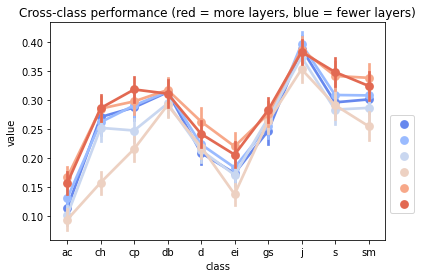

In [30]:
compare_models = ['wet_5_1014', 'wet_45_1014', 'wet_3456_1014', 'wet_234567_1014', 'wet_12345678_1014', 'wet_0123456789_1014']
cross_class_compare = wet_df[wet_df['version'].isin(compare_models)]
sns.pointplot(data=cross_class_compare, x='class', y='value', hue='version', palette=sns.color_palette("coolwarm"),\
              order=URBANSED_CLASSES, hue_order=compare_models, ci='sd', legend_out=True, jitter=True)

plt.gca().legend(bbox_to_anchor=(1,.1, .1,2), mode='expand', loc='lower left')
plt.gca().set_xticklabels(class_labels)
plt.title('Cross-class performance (red = more layers, blue = fewer layers)')

No handles with labels found to put in legend.


Text(0.5, 1.0, 'Micro-Averaged F1 across models')

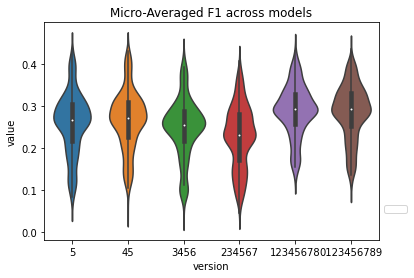

In [31]:
sns.violinplot(data=cross_class_compare, x='version', y='value',\
               order=compare_models, ci='sd', legend_out=True)

model_labels = [model.split('_')[1] for model in compare_models]
plt.gca().legend(bbox_to_anchor=(1,.1, .1,2), mode='expand', loc='lower left')
plt.gca().set_xticklabels(model_labels)
plt.title('Micro-Averaged F1 across models')

No handles with labels found to put in legend.


Text(0.5, 1.0, 'Micro-Averaged F1 STD across models')

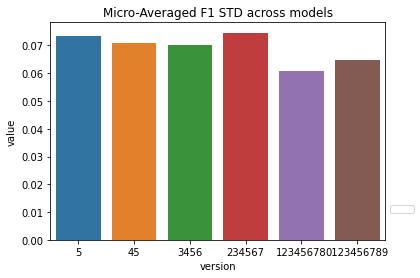

In [32]:
cross_class_std = cross_class_compare.groupby('version').std().reset_index()
sns.barplot(data=cross_class_std, x='version', y='value',\
           order=compare_models, ci=None)

plt.gca().legend(bbox_to_anchor=(1,.1, .1,2), mode='expand', loc='lower left')
plt.gca().set_xticklabels(model_labels)
plt.title('Micro-Averaged F1 STD across models')

No handles with labels found to put in legend.


Text(0.5, 1.0, 'Macro-Averaged F1 across models')

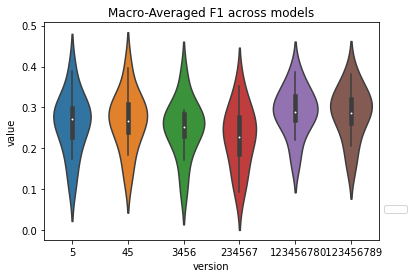

In [33]:
class_aggregate = cross_class_compare.groupby(['version', 'class']).mean().reset_index()
sns.violinplot(data=class_aggregate, x='version', y='value',\
               order=compare_models, ci='sd', legend_out=True)

model_labels = [model.split('_')[1] for model in compare_models]
plt.gca().legend(bbox_to_anchor=(1,.1, .1,2), mode='expand', loc='lower left')
plt.gca().set_xticklabels(model_labels)
plt.title('Macro-Averaged F1 across models')

No handles with labels found to put in legend.


Text(0.5, 1.0, 'Macro-Averaged F1 STD across models')

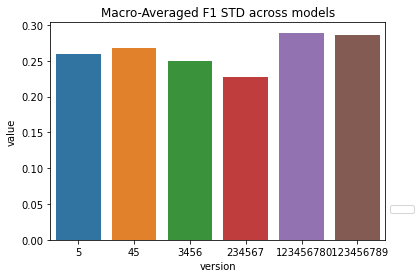

In [34]:
group_std = class_aggregate.groupby('version').std().reset_index()
sns.barplot(data=class_aggregate, x='version', y='value',\
           order=compare_models, ci=None)

plt.gca().legend(bbox_to_anchor=(1,.1, .1,2), mode='expand', loc='lower left')
plt.gca().set_xticklabels(model_labels)
plt.title('Macro-Averaged F1 STD across models')

<ipython-input-35-6e755eca3d10>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  f1_df = sample_df[sample_df['metric']=='f_measure']\


Text(0.5, 1.0, 'Overall F1 Scores Across Models (dry)')

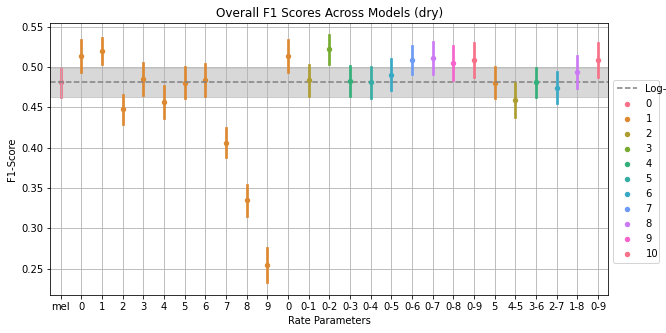

In [35]:
f1_df = sample_df[sample_df['metric']=='f_measure']\
                 [sample_df['training_set']=='dry']\
                 [sample_df['eval_dataset']=='dry']\
                 [sample_df['class']=='overall']
f1_single_df = f1_df[f1_df['num_slices']==1]
f1_increasing_df = f1_df[f1_df['slices'].isin(slices_multiple)]
f1_midout_df = f1_df[f1_df['slices'].isin(slices_midout)]
f1_mel_df = f1_df[f1_df['num_slices']==0]

slices_all = ['mel'] + slices_single + slices_multiple + slices_midout
slice_labels = []
for slices in slices_all:
    if len(slices)==1 or slices=='mel':
        slice_labels.append(slices)
    else:
        slice_labels.append('{}-{}'.format(min(slices), max(slices)))

plt.figure(figsize=(10,5))
ax = sns.pointplot(x="slices", y="value", data=f1_df, palette=sns.color_palette('husl', 10), hue='num_slices', order=slices_all, ci='sd', join=False, markers='.')

logmel_mean = f1_mel_df['value'].mean()
logmel_std = f1_mel_df['value'].std()
ax.axhline(logmel_mean, color='grey', linestyle='--', label='Log-Mel-Spectrogram')
std_max = logmel_mean + logmel_std
std_min = logmel_mean - logmel_std
ax.axhspan(std_max, std_min, color='grey', alpha=.3)

ax.legend(bbox_to_anchor=(1,.1, .1,2), mode='expand', loc='lower left')
ax.set_xticklabels(slice_labels)
ax.set_xlabel('Rate Parameters')
ax.set_ylabel('F1-Score')
plt.grid()
plt.title('Overall F1 Scores Across Models (dry)')

<ipython-input-36-5324f7e30a28>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  f1_df = sample_df[sample_df['metric']=='f_measure']\


Text(0.5, 1.0, 'Overall F1 Scores Across Models (w/reverb)')

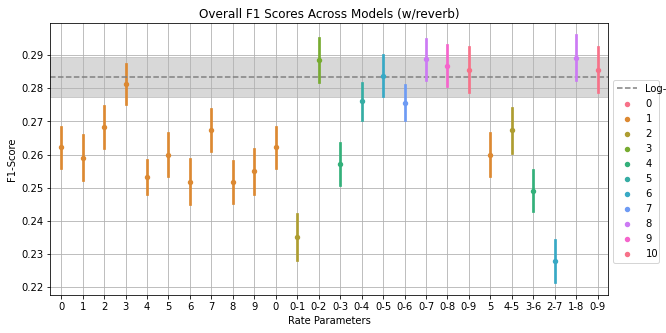

In [36]:
f1_df = sample_df[sample_df['metric']=='f_measure']\
                 [sample_df['training_set']=='wet']\
                 [sample_df['eval_dataset']=='wet']\
                 [sample_df['class']=='overall']
f1_single_df = f1_df[f1_df['num_slices']==1]
f1_increasing_df = f1_df[f1_df['slices'].isin(slices_multiple)]
f1_midout_df = f1_df[f1_df['slices'].isin(slices_midout)]
f1_mel_df = f1_df[f1_df['num_slices']==0]

slices_all = slices_single + slices_multiple + slices_midout
slice_labels = []
for slices in slices_all:
    if len(slices)==1:
        slice_labels.append(slices)
    else:
        slice_labels.append('{}-{}'.format(min(slices), max(slices)))

plt.figure(figsize=(10,5))
ax = sns.pointplot(x="slices", y="value", data=f1_df, palette=sns.color_palette('husl', 10), hue='num_slices', order=slices_all, ci='sd', join=False, markers='.')

logmel_mean = f1_mel_df['value'].mean()
logmel_std = f1_mel_df['value'].std()
ax.axhline(logmel_mean, color='grey', linestyle='--', label='Log-Mel-Spectrogram')
std_max = logmel_mean + logmel_std
std_min = logmel_mean - logmel_std
ax.axhspan(std_max, std_min, color='grey', alpha=.3)

ax.legend(bbox_to_anchor=(1,.1, .1,2), mode='expand', loc='lower left')
ax.set_xticklabels(slice_labels)
ax.set_xlabel('Rate Parameters')
ax.set_ylabel('F1-Score')
plt.grid()
plt.title('Overall F1 Scores Across Models (w/reverb)')

In [37]:
f1_df.groupby('version').mean()

,value,num_slices
version,,
wet_0123456789_1014,0.285637,10
wet_012345678_1014,0.286808,9
wet_01234567_1014,0.288747,8
wet_0123456_1014,0.275678,7
wet_012345_1014,0.283773,6
wet_01234_1014,0.276033,5
wet_0123_1014,0.257132,4
wet_012_1014,0.288591,3
wet_01_1014,0.235135,2


<ipython-input-164-ed82e988c116>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  f1_df = sample_df[sample_df['metric']=='f_measure']\
<ipython-input-164-ed82e988c116>:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  f1_overall_df = f1_df[f1_df['class']=='overall']\
<ipython-input-164-ed82e988c116>:25: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  f1_optmulti_df =  sample_df[sample_df['metric']=='f_measure']\
<ipython-input-164-ed82e988c116>:30: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  f1_df = sample_df[sample_df['metric']=='f_measure']\


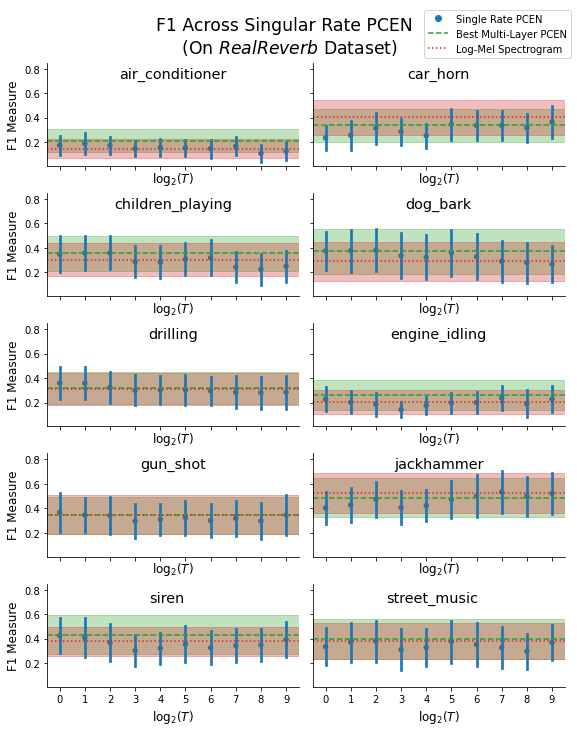

In [164]:
f1_df = sample_df[sample_df['metric']=='f_measure']\
                 [sample_df['training_set']=='realreverb']\
                 [sample_df['eval_dataset'].isin(real_reverb_set)]\

f1_single_df = f1_df[f1_df['num_slices']==1]
f1_increasing_df = f1_df[f1_df['slices'].isin(slices_multiple)]
f1_midout_df = f1_df[f1_df['slices'].isin(slices_midout)]
f1_logmel_df = f1_df[f1_df['num_slices']==0]

sample_logmel_df = sample_df[sample_df['slices']=='mel']

f1_overall_df = f1_df[f1_df['class']=='overall']\
                     [f1_df['slices'].isin(slices_midout)]\
                     [f1_df['slices'].isin(slices_multiple)]

f1_overall_gb = f1_overall_df.groupby(['slices'])

means = f1_overall_gb['value'].mean()
stds = f1_overall_gb['value'].std()
max_multi_val = means.max()
max_multi_slice = means[means==max_multi_val].index.tolist()[0]
max_multi_std = stds[max_multi_slice]

#dataframe for overall optimal multilayer model
f1_optmulti_df =  sample_df[sample_df['metric']=='f_measure']\
                 [sample_df['training_set']=='realreverb']\
                 [sample_df['eval_dataset'].isin(real_reverb_set)]\
                 [sample_df['slices']==max_multi_slice]

f1_df = sample_df[sample_df['metric']=='f_measure']\
                 [sample_df['training_set']=='realreverb']\
                 [sample_df['eval_dataset'].isin(real_reverb_set)]
f1_single_df = f1_df[f1_df['num_slices']==1]


class_order = URBANSED_CLASSES
#filter out "overall"
sub_df = f1_single_df[f1_single_df['class'].isin(class_order)]

#generate colors
colors = sns.color_palette(palette='Set1', n_colors=len(class_order))

#build facet_grid
g = sns.FacetGrid(sub_df, col="class", col_order=class_order, col_wrap=2, aspect=2,\
                  height=2, legend_out=True)

#measure mean and best model by average performance
means_df = f1_single_df.groupby(['class'])
max_coords = {}
for name, group in means_df:
    means = group.groupby('slices').mean()
    stds = group.groupby('slices').std()
    max_val = means['value'].max()
    max_slice = means[means['value']==max_val].index.tolist()[0]
    max_coords[name] = (max_slice, max_val)
    

#compute mean and std of optimal model on each class
multiopt_df = f1_optmulti_df.groupby(['class'])
max_opt_multi_coords = {}
for name, group in multiopt_df:
    means = group.groupby('slices').mean()
    stds = group.groupby('slices').std()
    opt_multi_val = means.iloc[0]['value']
    opt_multi_std = stds.iloc[0]['value']
    max_opt_multi_coords[name] = (opt_multi_val, opt_multi_std)
    
#compute mean and std of logmel on each class
logmel_classes_gb = f1_logmel_df.groupby(['class'])
max_logmel_coords = {}
for name, group in logmel_classes_gb:
    mean = group['value'].mean()
    std = group['value'].std()
    max_logmel_coords[name] = (mean, std)

#pointplots
order_array = [str(i) for i in np.arange(10)]
g.map(sns.pointplot, "slices", "value", ci='sd',order=order_array, join=False, markers='.')

#plot maximal values/model params
for i, ax in enumerate(g.axes):
    key = class_order[i]
    x, y = max_coords[key]

    opt_multi_val, opt_multi_std =  max_opt_multi_coords[key]
    ax.axhline(opt_multi_val, color='C2', linestyle='--')
    std_max = opt_multi_val + opt_multi_std
    std_min = opt_multi_val - opt_multi_std
    ax.axhspan(std_max, std_min, color='C2', alpha=.3)
    
    logmel_mean, logmel_std =  max_logmel_coords[key]
    ax.axhline(logmel_mean, color='C3', linestyle=':')
    std_max = logmel_mean + logmel_std
    std_min = logmel_mean - logmel_std
    ax.axhspan(std_max, std_min, color='C3', alpha=.3)
    
    if i%2 == 0:
        ax.set_ylabel('F1 Measure',fontsize='large')
    if True:#i>7:
        ax.set_xlabel(r'$\log_2 (T)$',fontsize='large')
        
    class_label = ax.title.get_text().split(' ')[-1]
    if class_label not in ['siren','street_music']:
        ax.set_title(class_label, fontsize='x-large', y=1,pad=-15)
    else:
        ax.set_title('')
        ax.text(s=class_label, fontsize='x-large', x=4.25, y=.7, horizontalalignment='center')
    ax.set_ylim(top=.85)
        

#add title   
plt.subplots_adjust(top=0.925)
g.fig.suptitle('F1 Across Singular Rate PCEN \n (On $\\it{RealReverb}$ Dataset)', fontsize='xx-large', x=.5, y=.99) #($\it{Real Reverb}$)

#customize legend
legend_elements = []
legend_elements.append(Line2D([0], [0], color='C0', marker='o', linestyle='None', label='Single Rate PCEN'))
legend_elements.append(Line2D([0], [0], color='C2', linestyle='--', label="Best Multi-Layer PCEN"))
legend_elements.append(Line2D([0], [0], color='C3', linestyle=':', label="Log-Mel Spectrogram"))

#g.axes.flatten()[-1].legend(handles=legend_elements, loc='lower left')
g.fig.legend(bbox_to_anchor=(1, 1.01), loc='upper right',handles=legend_elements)
#g.fig.text(0.15, .95, '\nDataset: RealReverb', ha='center', bbox=dict(facecolor='0.95'), fontsize='large')
g.fig.savefig('singlerate_compare_rr.pdf', format='pdf')


<ipython-input-39-8083d4e2e438>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  f1_df = sample_df[sample_df['metric']=='f_measure']\
<ipython-input-39-8083d4e2e438>:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  f1_overall_df = f1_df[f1_df['class']=='overall']\
<ipython-input-39-8083d4e2e438>:25: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  f1_optmulti_df =  sample_df[sample_df['metric']=='f_measure']\
<ipython-input-39-8083d4e2e438>:30: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  f1_df = sample_df[sample_df['metric']=='f_measure']\
/scratch/ci411/.conda/envs/py3.8/lib/python3.8/site-packages/seaborn/axisgrid.py:643: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


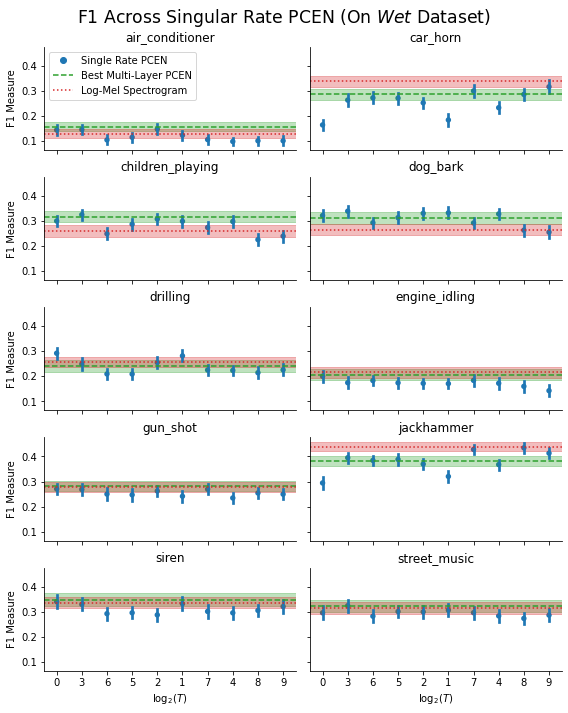

In [39]:
f1_df = sample_df[sample_df['metric']=='f_measure']\
                 [sample_df['training_set']=='wet']\
                 [sample_df['eval_dataset']=='wet']\

f1_single_df = f1_df[f1_df['num_slices']==1]
f1_increasing_df = f1_df[f1_df['slices'].isin(slices_multiple)]
f1_midout_df = f1_df[f1_df['slices'].isin(slices_midout)]
f1_logmel_df = f1_df[f1_df['num_slices']==0]

sample_logmel_df = sample_df[sample_df['slices']=='mel']

f1_overall_df = f1_df[f1_df['class']=='overall']\
                     [f1_df['slices'].isin(slices_midout)]\
                     [f1_df['slices'].isin(slices_multiple)]

f1_overall_gb = f1_overall_df.groupby(['slices'])

means = f1_overall_gb['value'].mean()
stds = f1_overall_gb['value'].std()
max_multi_val = means.max()
max_multi_slice = means[means==max_multi_val].index.tolist()[0]
max_multi_std = stds[max_multi_slice]

#dataframe for overall optimal multilayer model
f1_optmulti_df =  sample_df[sample_df['metric']=='f_measure']\
                 [sample_df['training_set']=='wet']\
                 [sample_df['eval_dataset']=='wet']\
                 [sample_df['slices']==max_multi_slice]

f1_df = sample_df[sample_df['metric']=='f_measure']\
                 [sample_df['training_set']=='wet']\
                 [sample_df['eval_dataset']=='wet']
f1_single_df = f1_df[f1_df['num_slices']==1]


class_order = URBANSED_CLASSES
#filter out "overall"
sub_df = f1_single_df[f1_single_df['class'].isin(class_order)]

#generate colors
colors = sns.color_palette(palette='Set1', n_colors=len(class_order))

#build facet_grid
g = sns.FacetGrid(sub_df, col="class", col_order=class_order,col_wrap=2, aspect=2,\
                  height=2, legend_out=True)#, hue='class', palette='Set1')

#measure mean and best model by average performance
means_df = f1_single_df.groupby(['class'])
max_coords = {}
for name, group in means_df:
    means = group.groupby('slices').mean()
    stds = group.groupby('slices').std()
    max_val = means['value'].max()
    max_slice = means[means['value']==max_val].index.tolist()[0]
    max_coords[name] = (max_slice, max_val)
    

#compute mean and std of optimal model on each class
multiopt_df = f1_optmulti_df.groupby(['class'])
max_opt_multi_coords = {}
for name, group in multiopt_df:
    means = group.groupby('slices').mean()
    stds = group.groupby('slices').std()
    opt_multi_val = means.iloc[0]['value']
    opt_multi_std = stds.iloc[0]['value']
    max_opt_multi_coords[name] = (opt_multi_val, opt_multi_std)
    
#compute mean and std of logmel on each class
logmel_classes_gb = f1_logmel_df.groupby(['class'])
max_logmel_coords = {}
for name, group in logmel_classes_gb:
    mean = group['value'].mean()
    std = group['value'].std()
    max_logmel_coords[name] = (mean, std)

#pointplots
g.map(sns.pointplot, "slices", "value", ci='sd', join=False, markers='.')

#plot maximal values/model params
for i, ax in enumerate(g.axes):
    key = class_order[i]
    x, y = max_coords[key]

    opt_multi_val, opt_multi_std =  max_opt_multi_coords[key]
    ax.axhline(opt_multi_val, color='C2', linestyle='--')
    std_max = opt_multi_val + opt_multi_std
    std_min = opt_multi_val - opt_multi_std
    ax.axhspan(std_max, std_min, color='C2', alpha=.3)
    
    logmel_mean, logmel_std =  max_logmel_coords[key]
    ax.axhline(logmel_mean, color='C3', linestyle=':')
    std_max = logmel_mean + logmel_std
    std_min = logmel_mean - logmel_std
    ax.axhspan(std_max, std_min, color='C3', alpha=.3)
    
    if i%2 == 0:
        ax.set_ylabel('F1 Measure')
    if i>7:
        ax.set_xlabel(r'$\log_2 (T)$')
        
    class_label = ax.title.get_text().split(' ')[-1]
    ax.set_title(class_label)
        

#add title   
plt.subplots_adjust(top=0.925)
g.fig.suptitle(r'F1 Across Singular Rate PCEN (On $\it{Wet}$ Dataset)', fontsize='xx-large')

#customize legend
legend_elements = []
legend_elements.append(Line2D([0], [0], color='C0', marker='o', linestyle='None', label='Single Rate PCEN'))
legend_elements.append(Line2D([0], [0], color='C2', linestyle='--', label="Best Multi-Layer PCEN"))
legend_elements.append(Line2D([0], [0], color='C3', linestyle=':', label="Log-Mel Spectrogram"))

g.axes.flatten()[0].legend(handles=legend_elements, loc='upper left')
g.fig.savefig('singlerate_compare_wet.pdf', format='pdf')

<ipython-input-40-18e8cf041c12>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  f1_df = sample_df[sample_df['metric']=='f_measure']\
<ipython-input-40-18e8cf041c12>:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  f1_overall_df = f1_df[f1_df['class']=='overall']\
<ipython-input-40-18e8cf041c12>:25: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  f1_optmulti_df =  sample_df[sample_df['metric']=='f_measure']\
<ipython-input-40-18e8cf041c12>:30: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  f1_df = sample_df[sample_df['metric']=='f_measure']\
/scratch/ci411/.conda/envs/py3.8/lib/python3.8/site-packages/seaborn/axisgrid.py:643: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


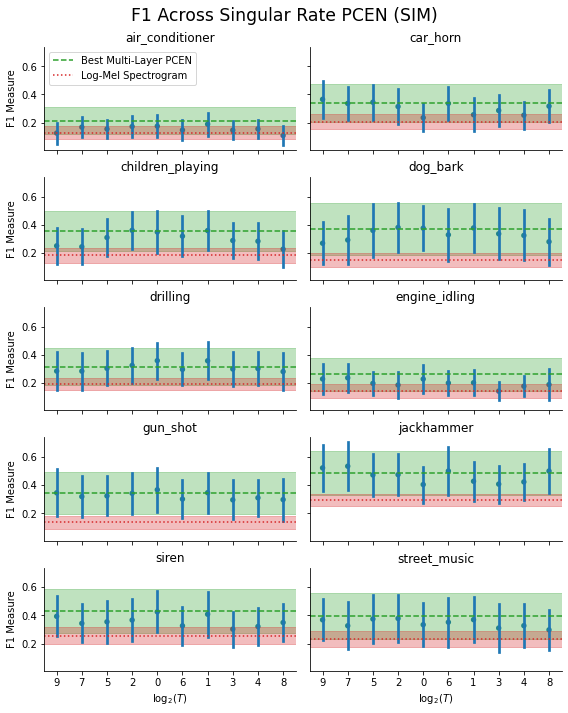

In [40]:
f1_df = sample_df[sample_df['metric']=='f_measure']\
                 [sample_df['training_set']=='simreverb']\
                 [sample_df['eval_dataset'].isin(sim_reverb_set)]\

f1_single_df = f1_df[f1_df['num_slices']==1]
f1_increasing_df = f1_df[f1_df['slices'].isin(slices_multiple)]
f1_midout_df = f1_df[f1_df['slices'].isin(slices_midout)]
f1_logmel_df = f1_df[f1_df['num_slices']==0]

sample_logmel_df = sample_df[sample_df['slices']=='mel']

f1_overall_df = f1_df[f1_df['class']=='overall']\
                     [f1_df['slices'].isin(slices_midout)]\
                     [f1_df['slices'].isin(slices_multiple)]

f1_overall_gb = f1_overall_df.groupby(['slices'])

means = f1_overall_gb['value'].mean()
stds = f1_overall_gb['value'].std()
max_multi_val = means.max()
max_multi_slice = means[means==max_multi_val].index.tolist()[0]
max_multi_std = stds[max_multi_slice]

#dataframe for overall optimal multilayer model
f1_optmulti_df =  sample_df[sample_df['metric']=='f_measure']\
                 [sample_df['training_set']=='realreverb']\
                 [sample_df['eval_dataset'].isin(real_reverb_set)]\
                 [sample_df['slices']==max_multi_slice]

f1_df = sample_df[sample_df['metric']=='f_measure']\
                 [sample_df['training_set']=='realreverb']\
                 [sample_df['eval_dataset'].isin(real_reverb_set)]
f1_single_df = f1_df[f1_df['num_slices']==1]


class_order = URBANSED_CLASSES
#filter out "overall"
sub_df = f1_single_df[f1_single_df['class'].isin(class_order)]

#generate colors
colors = sns.color_palette(palette='Set1', n_colors=len(class_order))

#build facet_grid
g = sns.FacetGrid(sub_df, col="class", col_order=class_order,col_wrap=2, aspect=2,\
                  height=2, legend_out=True)#, hue='class', palette='Set1')

#measure mean and best model by average performance
means_df = f1_single_df.groupby(['class'])
max_coords = {}
for name, group in means_df:
    means = group.groupby('slices').mean()
    stds = group.groupby('slices').std()
    max_val = means['value'].max()
    max_slice = means[means['value']==max_val].index.tolist()[0]
    max_coords[name] = (max_slice, max_val)
    

#compute mean and std of optimal model on each class
multiopt_df = f1_optmulti_df.groupby(['class'])
max_opt_multi_coords = {}
for name, group in multiopt_df:
    means = group.groupby('slices').mean()
    stds = group.groupby('slices').std()
    opt_multi_val = means.iloc[0]['value']
    opt_multi_std = stds.iloc[0]['value']
    max_opt_multi_coords[name] = (opt_multi_val, opt_multi_std)
    
#compute mean and std of logmel on each class
logmel_classes_gb = f1_logmel_df.groupby(['class'])
max_logmel_coords = {}
for name, group in logmel_classes_gb:
    mean = group['value'].mean()
    std = group['value'].std()
    max_logmel_coords[name] = (mean, std)

#pointplots
g.map(sns.pointplot, "slices", "value", ci='sd', join=False, markers='.')

#plot maximal values/model params
for i, ax in enumerate(g.axes):
    key = class_order[i]
    x, y = max_coords[key]

    opt_multi_val, opt_multi_std =  max_opt_multi_coords[key]
    ax.axhline(opt_multi_val, color='C2', linestyle='--')
    std_max = opt_multi_val + opt_multi_std
    std_min = opt_multi_val - opt_multi_std
    ax.axhspan(std_max, std_min, color='C2', alpha=.3)
    
    logmel_mean, logmel_std =  max_logmel_coords[key]
    ax.axhline(logmel_mean, color='C3', linestyle=':')
    std_max = logmel_mean + logmel_std
    std_min = logmel_mean - logmel_std
    ax.axhspan(std_max, std_min, color='C3', alpha=.3)
    
    if i%2 == 0:
        ax.set_ylabel('F1 Measure')
    if i>7:
        ax.set_xlabel(r'$\log_2 (T)$')
        
    class_label = ax.title.get_text().split(' ')[-1]
    ax.set_title(class_label)
        

#add title   
plt.subplots_adjust(top=0.925)
g.fig.suptitle('F1 Across Singular Rate PCEN (SIM)', fontsize='xx-large')

#customize legend
legend_elements = []#[Line2D([0], [0], marker='o', color=colors[i], label=class_order[i])\
                  #for i in range(len(class_order))]
legend_elements.append(Line2D([0], [0], color='C2', linestyle='--', label="Best Multi-Layer PCEN"))
legend_elements.append(Line2D([0], [0], color='C3', linestyle=':', label="Log-Mel Spectrogram"))

g.axes.flatten()[0].legend(handles=legend_elements, loc='upper left')
g.fig.savefig('singlerate_compare_sim.pdf', format='pdf')

<ipython-input-41-afe22f85f9cb>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  f1_df = sample_df[sample_df['metric']=='f_measure']\
<ipython-input-41-afe22f85f9cb>:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  f1_overall_df = f1_df[f1_df['class']=='overall']\
<ipython-input-41-afe22f85f9cb>:25: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  f1_optmulti_df =  sample_df[sample_df['metric']=='f_measure']\
<ipython-input-41-afe22f85f9cb>:30: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  f1_df = sample_df[sample_df['metric']=='f_measure']\
/scratch/ci411/.conda/envs/py3.8/lib/python3.8/site-packages/seaborn/axisgrid.py:643: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


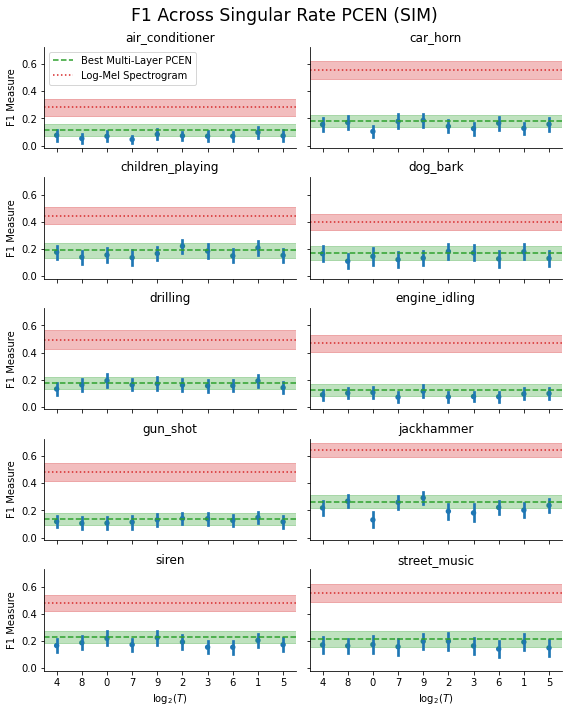

In [41]:
f1_df = sample_df[sample_df['metric']=='f_measure']\
                 [sample_df['training_set']=='dry']\
                 [sample_df['eval_dataset']=='dry']\

f1_single_df = f1_df[f1_df['num_slices']==1]
f1_increasing_df = f1_df[f1_df['slices'].isin(slices_multiple)]
f1_midout_df = f1_df[f1_df['slices'].isin(slices_midout)]
f1_logmel_df = f1_df[f1_df['num_slices']==0]

sample_logmel_df = sample_df[sample_df['slices']=='mel']

f1_overall_df = f1_df[f1_df['class']=='overall']\
                     [f1_df['slices'].isin(slices_midout)]\
                     [f1_df['slices'].isin(slices_multiple)]

f1_overall_gb = f1_overall_df.groupby(['slices'])

means = f1_overall_gb['value'].mean()
stds = f1_overall_gb['value'].std()
max_multi_val = means.max()
max_multi_slice = means[means==max_multi_val].index.tolist()[0]
max_multi_std = stds[max_multi_slice]

#dataframe for overall optimal multilayer model
f1_optmulti_df =  sample_df[sample_df['metric']=='f_measure']\
                 [sample_df['training_set']=='simreverb']\
                 [sample_df['eval_dataset'].isin(sim_reverb_set)]\
                 [sample_df['slices']==max_multi_slice]

f1_df = sample_df[sample_df['metric']=='f_measure']\
                 [sample_df['training_set']=='simreverb']\
                 [sample_df['eval_dataset'].isin(sim_reverb_set)]
f1_single_df = f1_df[f1_df['num_slices']==1]


class_order = URBANSED_CLASSES
#filter out "overall"
sub_df = f1_single_df[f1_single_df['class'].isin(class_order)]

#generate colors
colors = sns.color_palette(palette='Set1', n_colors=len(class_order))

#build facet_grid
g = sns.FacetGrid(sub_df, col="class", col_order=class_order,col_wrap=2, aspect=2,\
                  height=2, legend_out=True)#, hue='class', palette='Set1')

#measure mean and best model by average performance
means_df = f1_single_df.groupby(['class'])
max_coords = {}
for name, group in means_df:
    means = group.groupby('slices').mean()
    stds = group.groupby('slices').std()
    max_val = means['value'].max()
    max_slice = means[means['value']==max_val].index.tolist()[0]
    max_coords[name] = (max_slice, max_val)
    

#compute mean and std of optimal model on each class
multiopt_df = f1_optmulti_df.groupby(['class'])
max_opt_multi_coords = {}
for name, group in multiopt_df:
    means = group.groupby('slices').mean()
    stds = group.groupby('slices').std()
    opt_multi_val = means.iloc[0]['value']
    opt_multi_std = stds.iloc[0]['value']
    max_opt_multi_coords[name] = (opt_multi_val, opt_multi_std)
    
#compute mean and std of logmel on each class
logmel_classes_gb = f1_logmel_df.groupby(['class'])
max_logmel_coords = {}
for name, group in logmel_classes_gb:
    mean = group['value'].mean()
    std = group['value'].std()
    max_logmel_coords[name] = (mean, std)

#pointplots
g.map(sns.pointplot, "slices", "value", ci='sd', join=False, markers='.')

#plot maximal values/model params
for i, ax in enumerate(g.axes):
    key = class_order[i]
    x, y = max_coords[key]

    opt_multi_val, opt_multi_std =  max_opt_multi_coords[key]
    ax.axhline(opt_multi_val, color='C2', linestyle='--')
    std_max = opt_multi_val + opt_multi_std
    std_min = opt_multi_val - opt_multi_std
    ax.axhspan(std_max, std_min, color='C2', alpha=.3)
    
    logmel_mean, logmel_std =  max_logmel_coords[key]
    ax.axhline(logmel_mean, color='C3', linestyle=':')
    std_max = logmel_mean + logmel_std
    std_min = logmel_mean - logmel_std
    ax.axhspan(std_max, std_min, color='C3', alpha=.3)
    
    if i%2 == 0:
        ax.set_ylabel('F1 Measure')
    if i>7:
        ax.set_xlabel(r'$\log_2 (T)$')
        
    class_label = ax.title.get_text().split(' ')[-1]
    ax.set_title(class_label)
        

#add title   
plt.subplots_adjust(top=0.925)
g.fig.suptitle('F1 Across Singular Rate PCEN (SIM)', fontsize='xx-large')

#customize legend
legend_elements = []#[Line2D([0], [0], marker='o', color=colors[i], label=class_order[i])\
                  #for i in range(len(class_order))]
legend_elements.append(Line2D([0], [0], color='C2', linestyle='--', label="Best Multi-Layer PCEN"))
legend_elements.append(Line2D([0], [0], color='C3', linestyle=':', label="Log-Mel Spectrogram"))

g.axes.flatten()[0].legend(handles=legend_elements, loc='upper left')
g.fig.savefig('singlerate_compare_dry.pdf', format='pdf')

In [42]:
print(max_logmel_coords['street_music'])
print(max_opt_multi_coords['street_music'])

(0.5542222814492114, 0.06435762305789641)
(0.21772599276017884, 0.05931030394006422)


<ipython-input-43-85fc90baf287>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  f1_df = sample_df[sample_df['metric']=='f_measure']\
<ipython-input-43-85fc90baf287>:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  f1_overall_df = f1_df[f1_df['class']=='overall']\


slices
0123456789    0.508422
Name: value, dtype: float64
slices
0123456789    0.508422
Name: value, dtype: float64
0.5084216078043173
0123456789
0.02162674746080358


<ipython-input-43-85fc90baf287>:32: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  f1_optmulti_df =  sample_df[sample_df['metric']=='f_measure']\
<ipython-input-43-85fc90baf287>:37: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  f1_df = sample_df[sample_df['metric']=='f_measure']\
/scratch/ci411/.conda/envs/py3.8/lib/python3.8/site-packages/seaborn/axisgrid.py:643: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


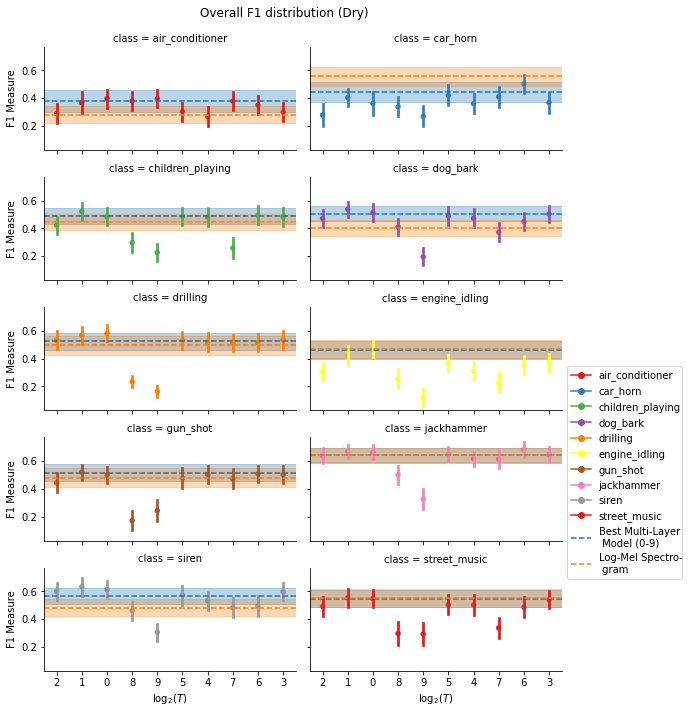

In [43]:
f1_df = sample_df[sample_df['metric']=='f_measure']\
                 [sample_df['training_set']=='dry']\
                 [sample_df['eval_dataset']=='dry']\

f1_single_df = f1_df[f1_df['num_slices']==1]
f1_increasing_df = f1_df[f1_df['slices'].isin(slices_multiple)]
f1_midout_df = f1_df[f1_df['slices'].isin(slices_midout)]
f1_logmel_df = f1_df[f1_df['num_slices']==0]

sample_logmel_df = sample_df[sample_df['slices']=='mel']

f1_overall_df = f1_df[f1_df['class']=='overall']\
                     [f1_df['slices'].isin(slices_midout)]\
                     [f1_df['slices'].isin(slices_multiple)]

f1_overall_gb = f1_overall_df.groupby(['slices'])

means = f1_overall_gb['value'].mean()
stds = f1_overall_gb['value'].std()
max_multi_val = means.max()
max_multi_slice = means[means==max_multi_val].index.tolist()[0]
max_multi_std = stds[max_multi_slice]
print(means[means==max_multi_val])
print(means)
print(max_multi_val)
print(max_multi_slice)
print(max_multi_std)



#dataframe for overall optimal multilayer model
f1_optmulti_df =  sample_df[sample_df['metric']=='f_measure']\
                 [sample_df['training_set']=='dry']\
                 [sample_df['eval_dataset']=='dry']\
                 [sample_df['slices']==max_multi_slice]

f1_df = sample_df[sample_df['metric']=='f_measure']\
                 [sample_df['training_set']=='dry']\
                 [sample_df['eval_dataset']=='dry']
f1_single_df = f1_df[f1_df['num_slices']==1]


class_order = URBANSED_CLASSES
#filter out "overall"
sub_df = f1_single_df[f1_single_df['class'].isin(class_order)]

#generate colors
colors = sns.color_palette(palette='Set1', n_colors=len(class_order))

#build facet_grid
g = sns.FacetGrid(sub_df, col="class", col_order=class_order,col_wrap=2, aspect=2,\
                  height=2, hue='class', palette='Set1', legend_out=True)

#measure mean and best model by average performance
means_df = f1_single_df.groupby(['class'])
max_coords = {}
for name, group in means_df:
    means = group.groupby('slices').mean()
    stds = group.groupby('slices').std()
    max_val = means['value'].max()
    max_slice = means[means['value']==max_val].index.tolist()[0]
    max_coords[name] = (max_slice, max_val)
    

#compute mean and std of optimal model on each class
multiopt_df = f1_optmulti_df.groupby(['class'])
max_opt_multi_coords = {}
for name, group in multiopt_df:
    means = group.groupby('slices').mean()
    stds = group.groupby('slices').std()
    opt_multi_val = means.iloc[0]['value']
    opt_multi_std = stds.iloc[0]['value']
    max_opt_multi_coords[name] = (opt_multi_val, opt_multi_std)
    
#compute mean and std of logmel on each class
logmel_classes_gb = f1_logmel_df.groupby(['class'])
max_logmel_coords = {}
for name, group in logmel_classes_gb:
    mean = group['value'].mean()
    std = group['value'].std()
    max_logmel_coords[name] = (mean, std)

#pointplots
g.map(sns.pointplot, "slices", "value", ci='sd', join=False, markers='.')

#plot maximal values/model params
for i, ax in enumerate(g.axes):
    key = class_order[i]
    x, y = max_coords[key]

    opt_multi_val, opt_multi_std =  max_opt_multi_coords[key]
    ax.axhline(opt_multi_val, color='C0', linestyle='--')
    std_max = opt_multi_val + opt_multi_std
    std_min = opt_multi_val - opt_multi_std
    ax.axhspan(std_max, std_min, color='C0', alpha=.3)
    
    logmel_mean, logmel_std =  max_logmel_coords[key]
    ax.axhline(logmel_mean, color='C1', linestyle='--')
    std_max = logmel_mean + logmel_std
    std_min = logmel_mean - logmel_std
    ax.axhspan(std_max, std_min, color='C1', alpha=.3)
    
    if i%2 == 0:
        ax.set_ylabel('F1 Measure')
    if i>7:
        ax.set_xlabel(r'$\log_2 (T)$')
        

#add title   
plt.subplots_adjust(top=0.925)
#g.set(ylim=(0,.85))
g.fig.suptitle('Overall F1 distribution (Dry)')

#customize legend
legend_elements = [Line2D([0], [0], marker='o', color=colors[i], label=class_order[i])\
                  for i in range(len(class_order))]
legend_elements.append(Line2D([0], [0], color='C0', linestyle='--', label="Best Multi-Layer\n Model ({}-{})".format(min(max_multi_slice), max(max_multi_slice))))
legend_elements.append(Line2D([0], [0], color='C1', linestyle='--', label="Log-Mel Spectro-\n gram"))



plt.legend(handles=legend_elements, bbox_to_anchor=(1,1,.5,2), mode='expand', loc='upper left')

In [44]:
#declare paths
audio_path = "/beegfs/ci411/pcen/reverb_pitch_URBAN-SED/audio"
annotations_path = "/beegfs/ci411/pcen/reverb_pitch_URBAN-SED/annotations"

pcen_path = "/beegfs/ci411/pcen/features_807/pcen"
mel_path = "/beegfs/ci411/pcen/features_807/mel"
models_path = '/beegfs/ci411/pcen/models/models_1014'


#select example file
test_file = 'soundscape_train_bimodal1798_tunnel'
semitone = '0'

#declare audio/feature paths of example
test_audio = os.path.join(audio_path, 'train', test_file + '_{}.wav'.format(semitone))
test_annotations = os.path.join(annotations_path, 'train', test_file + '_{}.jams'.format(semitone))

test_pcen = os.path.join(pcen_path,'URBAN-SED_tunnel', 'train', test_file +'_{}.h5'.format(semitone))
test_mel = os.path.join(mel_path, 'URBAN-SED_tunnel', 'train', test_file +'_{}.h5'.format(semitone))

#declare specific example models
pcen_model_name = 'wet_0123456789_model1014'
pcen_model_path = os.path.join(models_path, pcen_model_name, 'model.yaml')
pcen_model_weights = os.path.join(models_path, pcen_model_name, 'model.h5')
mel_model_name = 'wet_mel_model1014'
mel_model_path = os.path.join(models_path, mel_model_name, 'model.yaml')
mel_model_weights = os.path.join(models_path, mel_model_name, 'model.h5')

#load features/labels
pcen_all = load_h5(test_pcen)
mel_all = load_h5(test_mel)

#ensure labels are identical
pcen_labels = pcen_all['dynamic/tags']
mel_labels = mel_all['dynamic/tags']
assert (pcen_labels==mel_labels).all()

#store labels
true_tags = max_pool(pcen_labels)[0]

#store features
pcen_data = pcen_all['PCEN/mag'][0,:,:,2].T
mel_data = mel_all['Mel/mag'][0,:,:,0].T

#import models
with open(pcen_model_path, 'r') as pcen_yaml_file:
    pcen_model_yaml = pcen_yaml_file.read()
    pcen_model = model_from_yaml(pcen_model_yaml, custom_objects={'SqueezeLayer':SqueezeLayer})
    pcen_model.load_weights(pcen_model_weights)
with open(mel_model_path, 'r') as mel_yaml_file:
    mel_model_yaml = mel_yaml_file.read()
    mel_model = model_from_yaml(mel_model_yaml, custom_objects={'SqueezeLayer':SqueezeLayer})
    mel_model.load_weights(mel_model_weights)
    
#extract predictions
pcen_preds = pcen_model.predict(pcen_all['PCEN/mag'])[0] #note slices are tricky
mel_preds = mel_model.predict(mel_all['Mel/mag'])[0]



OSError: Unable to open file (unable to open file: name = '/beegfs/ci411/pcen/features_807/pcen/URBAN-SED_tunnel/train/soundscape_train_bimodal1798_tunnel_0.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
for key in list(pcen_all.keys()):
    if 'mag' in key:
        print(key)

In [ ]:
fig, ax = plt.subplots(nrows=5, figsize=(14,12), sharex=True)
xlim=(0,10)

#plot tags
cf_tags = specshow(true_tags.T, ax=ax[0], x_axis='time', sr= 22050, hop_length=1024*16)
ax[0].label_outer()
ax[0].set_xlim(xlim)
ax[0].set_yticks(np.arange(len(URBANSED_CLASSES))+.5)
ax[0].set_yticklabels(labels=URBANSED_CLASSES)


#plot predictions
cf_pcen_pred = specshow(pcen_preds.T, ax=ax[1], x_axis='time', sr= 22050, hop_length=1024*16)#ax[1].pcolormesh(, vmin=0, vmax=1)
ax[1].label_outer()
ax[1].set_xlim(xlim)
ax[1].set_yticks(np.arange(len(URBANSED_CLASSES))+.5)
ax[1].set_yticklabels(labels=URBANSED_CLASSES)
ax[1].set_title(pcen_model_name + " predictions")

cf_mel_pred = specshow(mel_preds.T, ax=ax[2], x_axis='time', sr= 22050, hop_length=1024*16)#ax[2].pcolormesh(mel_preds.T, vmin=0, vmax=1)
ax[2].label_outer()
ax[2].set_xlim(xlim)
ax[2].set_yticks(np.arange(len(URBANSED_CLASSES))+.5)
ax[2].set_yticklabels(labels=URBANSED_CLASSES)
ax[2].set_title(mel_model_name + " predictions")


#plot audio
cf_pcen = specshow(pcen_data, ax=ax[3], x_axis='time', sr= 22050, hop_length=1024)#ax[3].pcolormesh(pcen_data, vmin=0, vmax=1)
ax[3].label_outer()
ax[3].set_xlim(xlim)
ax[3].set_yticks([])
ax[3].set_title('PCEN Spectrogram (One layer)')

cf_mel = specshow(mel_data, ax=ax[4], x_axis='time', sr= 22050, hop_length=1024)
ax[4].label_outer()
ax[4].set_xlim(xlim)
ax[4].set_yticks([])
ax[4].set_title("Log-Scaled Mel-Spectrogram")

Audio(test_audio)

In [ ]:
from librosa.display import specshow
from pcen_t.utils import *
from keras.models import model_from_yaml

def plot_preds(model_path, feature_path, label_ax=None, spec_ax=None, slices=[0], plot_slice=0):
    #load models
    with open(os.path.join(model_path,'model.yaml'), 'r') as model_yaml:
        model = model_from_yaml(model_yaml.read(), custom_objects={'SqueezeLayer':SqueezeLayer})
        model.load_weights(os.path.join(model_path,'model.h5'))
    
    #load features
    all_data = load_h5(feature_path)
    data_key = ''
    
    #extract key for features
    for key in list(all_data.keys()):
        if 'mag' in key:
            data_key = key
    data = all_data[data_key]
    
    #extract/pool labels
    labels = max_pool(all_data['dynamic/tags'])[0]

    #compute predictions
    preds = model.predict(data[:,:,:,slices])[0]
    
    #plot results
    if label_ax is not None:
        specshow(preds.T, ax=label_ax, sr=22050, hop_length=1024*16)
        label_ax.set_yticks(np.arange(len(URBANSED_CLASSES))+.5)
        label_ax.set_yticklabels(labels=URBANSED_CLASSES)
        
    if spec_ax is not None:
        specshow(data[0,:,:,plot_slice].T, ax=spec_ax, x_axis='time', sr=22050, hop_length=1024)

In [ ]:
fig, ax = plt.subplots(nrows=4, figsize=(14,12), sharex=True)

model_test_folder = os.path.join(models_path, pcen_model_name)
feature_test = os.path.join(pcen_path,'URBAN-SED_tunnel', 'train', test_file +'_{}.h5'.format(semitone))
plot_preds(model_test_folder, feature_test, label_ax=ax[0], spec_ax=ax[1], plot_slice=4, slices=np.arange(10))

model_test_folder = os.path.join(models_path, mel_model_name)
feature_test = os.path.join(mel_path,'URBAN-SED_tunnel', 'train', test_file +'_{}.h5'.format(semitone))
plot_preds(model_test_folder, feature_test, label_ax=ax[2], spec_ax=ax[3])

for axi in ax:
    axi.label_outer()
    axi.set_xlim(xlim)

In [ ]:
overall_f1_df = sample_df[sample_df['class/metric']=='overall_f1']

In [ ]:
wet_overall_f1_df = overall_f1_df[overall_f1_df['training_set']=='wet']\
                                 [overall_f1_df['eval_dataset']=='wet']

In [ ]:
wof1_5_df = wet_overall_f1_df[wet_overall_f1_df['slices']=='5']
wof1_5_df['value'].hist(bins=30)

In [ ]:
wof1_0_9_df = wet_overall_f1_df[wet_overall_f1_df['slices']=='0123456789']
wof1_0_9_df['value'].hist(bins=30)

In [ ]:
wof1_mel_df = wet_overall_f1_df[wet_overall_f1_df['slices']=='mel']
wof1_mel_df['value'].hist(bins=30)

In [ ]:
dry_overall_df = sample_df[sample_df['training_set']=='dry']\
                                 [sample_df['eval_dataset']=='dry']

do_mel_df = dry_overall_df[dry_overall_df['slices']=='mel']\
                          [dry_overall_df['metric']=='f_measure']

do_mel_df['value'].hist(bins=30)

In [ ]:
do_mel_df['value'].mean()